In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector 

db = mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = '',
                             database = 'ecommerce_customers')

cur = db.cursor()

### 1. Calculate the number of orders per month in 2018.

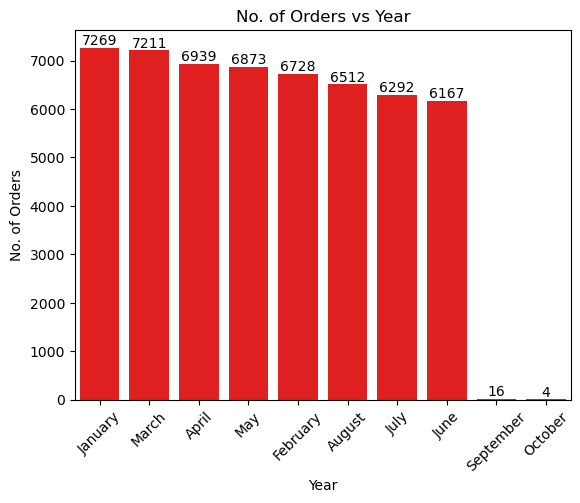

In [2]:
query = '''
           select monthname(order_purchase_timestamp), count(order_id)
           from orders
           where year(order_purchase_timestamp) = 2018
           group by monthname(order_purchase_timestamp)
           '''

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['Year', 'No. of Orders'])
df = df.sort_values(by='No. of Orders', ascending=False)
ax = sns.barplot(x=df['Year'], y=df['No. of Orders'], data=df, color='red')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("No. of Orders vs Year")
plt.show()

### 2. Find the average number of products per order, grouped by customer city.

In [3]:
query = '''
           with order_count as (select orders.customer_id, count(order_items.order_id) as oc
from orders 
join order_items
on orders.order_id = order_items.order_id
group by orders.customer_id, orders.order_id)

select customers.customer_city, round(avg(order_count.oc),2)
from customers
join order_count 
on customers.customer_id = order_count.customer_id
group by customers.customer_city;
           '''

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=['Customer City','Average Product per Order'])
df.head()

,Customer City,Average Product per Order
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15


### 3. Calculate the percentage of total revenue contributed by each product category.

In [4]:
query = '''
         
with product_ordered as (select products.product_category, order_items.order_id
from products
join order_items
on products.product_id = order_items.product_id)

select product_ordered.product_category, (sum(payments.payment_value)/(select sum(payments.payment_value) from payments))*100 as sales_amount_percentage
from product_ordered
join payments 
on product_ordered.order_id = payments.order_id
where product_ordered.product_category is not null
group by product_ordered.product_category
order by sales_amount_percentage desc
           '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Product Category','Sales Percentage'])
df

,Product Category,Sales Percentage
0,bed table bath,10.697529
1,HEALTH BEAUTY,10.352841
2,computer accessories,9.902824
3,Furniture Decoration,8.933649
4,Watches present,8.927654
...,...,...
68,PC Gamer,0.013583
69,House Comfort 2,0.010685
70,cds music dvds,0.007492
71,Fashion Children's Clothing,0.004908


### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [5]:
query = '''
           select products.product_id,count(products.product_id) as Number_of_times_purchased, round(avg(order_items.price),2) as Average_Price
from products
join order_items
on products.product_id = order_items.product_id
group by products.product_id
           '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Product Id','Frequency of purchase', 'Avg Price'])
df = df.drop(columns=['Product Id'])
df = df.sort_values(by='Avg Price', ascending=False)
print("Correlation: ",df.corr()['Avg Price']['Frequency of purchase'])

Correlation:  -0.032139852542980026


### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

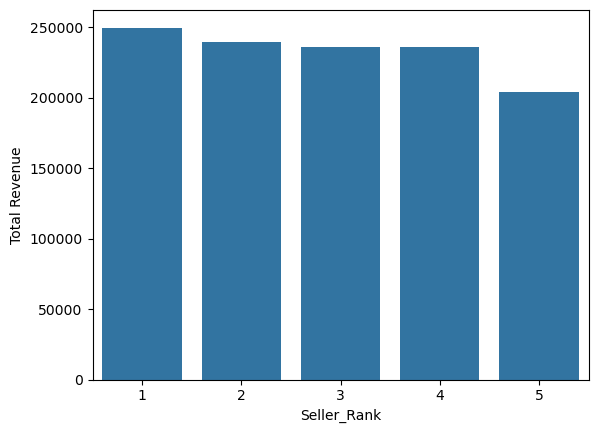

In [18]:
query = '''
        select sellers.seller_id,round(sum(order_items.price + freight_value),2) as Total_Revenue , dense_rank() over(order by sum(order_items.price + freight_value) desc) as Seller_Rank
from sellers
join order_items 
on sellers.seller_id = order_items.seller_id
group by sellers.seller_id;
           '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Seller Id','Total Revenue','Seller_Rank'])
df = df.head()
sns.barplot(x=df['Seller_Rank'],y=df['Total Revenue'],data=df)
# plt.xticks(rotation = 100)
plt.show()